Read all sheets from input Excel into single dataframe

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load spreadsheet using openpyxl
xl = pd.ExcelFile('JC1_all_compounds.xlsx', engine='openpyxl')

# Get the names of all sheets in the Excel file
sheet_names = xl.sheet_names

# Create a list to store all dataframes
all_dfs = []

# Read each sheet into a separate dataframe and add to the list
for sheet in sheet_names:
    df = xl.parse(sheet)
    
    # Rename columns not containing "SNCA" or "GC" with the sheet name as prefix
    df.columns = [f'{sheet}_{col}' if 'SNCA' not in col and 'GC' not in col else col for col in df.columns]
    
    # Remove any columns named 'Unnamed: 1'
    # Get a list of all columns that contain 'Unnamed: 1'
    cols_to_drop = [col for col in df.columns if 'Unnamed: 1' in col]

    # Drop these columns from the dataframe
    df = df.drop(columns=cols_to_drop)
    
    all_dfs.append(df)

# Concatenate all dataframes into a single dataframe
final_df = pd.concat(all_dfs, ignore_index=True)


Reorganize data

In [7]:
# Melt the dataframe to create a tidy dataframe
tidy_df = final_df.melt(var_name='column', value_name='value')

# Remove stars from data
tidy_df['value'] = tidy_df['value'].astype(str).str.replace(r'\*', '', regex=True)

# Remove rows with non-numeric values in 'value'
tidy_df = tidy_df[pd.to_numeric(tidy_df['value'], errors='coerce').notnull()]

# Create compound column containing info about used treatment
tidy_df['Compound'] = tidy_df['column'].apply(lambda x: x.split('_')[0] if '_' in x else x)

In [8]:
# Assuming tidy_df is your DataFrame and 'column' is the column of interest
# Create a dictionary for the conversion
conversion_dict = {
    '_10nM': 1e-8,
    '_100nM': 1e-7,
    '_0.5μΜ': 0.5e-6,
    '_1μM': 1e-6,
    '_2.5μΜ': 2.5e-6,
    '_5μM': 5e-6,
    '_10μM': 10e-6
}

# Create a new column 'Concentration (M)' and initialize with 0
tidy_df['Concentration (M)'] = 0

# Iterate over the conversion_dict
for k, v in conversion_dict.items():
    # Find rows where 'column' contains the key
    mask = tidy_df['column'].str.contains(k, regex=False)
    # Update 'Concentration (M)' with the value
    tidy_df.loc[mask, 'Concentration (M)'] = v

# Convert 'value' column to numeric
tidy_df['value'] = pd.to_numeric(tidy_df['value'], errors='coerce')

Remove technical outliers

In [9]:
# Define a function to remove outliers based on standard deviation
def remove_outliers(group):
    mean = group['value'].mean()
    std_dev = group['value'].std()
    return group[np.abs(group['value'] - mean) <= 5 * std_dev]

# Apply the function to each category
tidy_df = tidy_df.groupby('column').apply(remove_outliers).reset_index(drop=True)

# Save to csv file
tidy_df.to_csv('JC1_all_compounds_for_plotting.csv')

Test plot

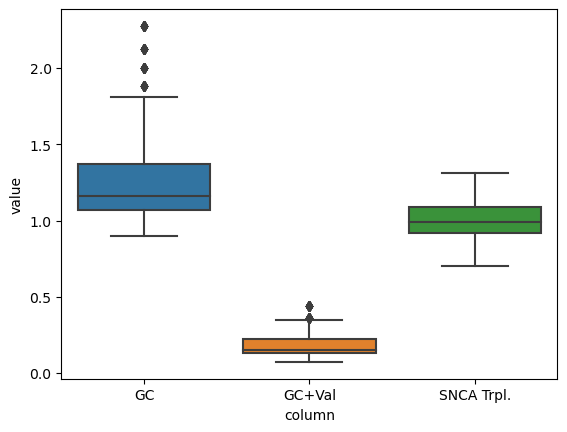

In [10]:
# Filter out rows in 'column' containing an underscore
tidy_df_filtered = tidy_df[~tidy_df['column'].str.contains('_')]

# Create a boxplot
sns.boxplot(x='column', y='value', data=tidy_df_filtered)

# Show the plot
plt.show()
